# ESTIMATION OF POPULATION EXPOSURE TO WIND SWATH

In [1]:
from pmap import *

In [2]:
import numpy as np

In [3]:
from mpl_toolkits.basemap import Basemap

In [4]:
import matplotlib.pyplot as plt 

In [5]:
import pyresample

In [6]:
import matplotlib

In [7]:
import matplotlib as mpl

In [8]:
import pandas as pd
import numpy as np
import urllib2,urllib


In [9]:
from colorb import *

In [10]:
#%matplotlib inline

In [11]:
%matplotlib notebook

## Read population data

In [12]:
# population data file
filename='../../POPEXPO/lspop20141.tif'

In [13]:
dataset=gdal.Open(filename) 

In [14]:
dataset.GetProjection()

'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AUTHORITY["EPSG","4326"]]'

In [15]:
width=dataset.RasterXSize
width

43200

In [16]:
height=dataset.RasterYSize
height

21600

In [17]:
gt=dataset.GetGeoTransform()
gt

(-180.0, 0.0083333333333333, 0.0, 89.99999999999929, 0.0, -0.0083333333333333)

In [18]:
minx = gt[0]                                                                                                                            
miny = gt[3] + width*gt[4] + height*gt[5]                                                                                               
maxx = gt[0] + width*gt[1] + height*gt[2]                                                                                               
maxy = gt[3]                                                                                                                            
                                                                                                                                          
lon=np.linspace(minx,maxx,width,endpoint=True)                                                                                          
lat=np.linspace(miny,maxy,height,endpoint=True)                                                                                         
                                                                                                                                          

In [19]:
lat=lat[::-1]

In [20]:
v = dataset.GetRasterBand(1)

In [21]:
nan=v.GetNoDataValue()

In [22]:
gdal.GetDataTypeName(v.DataType)

'Int32'

In [23]:
v.DataType

5

In [24]:
parallels = np.arange(-90.,90,20.)                                                                                                        
meridians = np.arange(0.,360.,20.)                                                                                                        

# TEST WITH TC

## read an old geotif file

In [25]:
wind=getmap('/mnt/pandora/Users_Critech/Brey/maptest/wind10mmalakas18w2016091600.tif')

In [26]:
wind

Bunch(CELLSIZE=0.04999999999999716, DRIVER='PCRaster Raster File', GeoTr=(106.75, 0.04999999999999716, 0.0, 53.1, 0.0, -0.04999999999999716), NCOLS=1225, NROWS=942, Proj='GEOGCS["GCS_WGS_1984",DATUM["WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]]', XSTART=106.75, YSTART=53.1, data=array([[-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       ..., 
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.],
       [-999., -999., -999., ..., -999., -999., -999.]], dtype=float32), lats=[], lons=[], nan=-3.4028234663852886e+38)

In [27]:
# compute lat/lon
widthw=wind.NCOLS
heightw=wind.NROWS
gw=wind.GeoTr
wminx = gw[0]                                                                                                                            
wminy = gw[3] + widthw*gw[4] + heightw*gw[5]                                                                                               
wmaxx = gw[0] + widthw*gw[1] + heightw*gw[2]                                                                                               
wmaxy = gw[3]                                                                                                                            
                                                                                                                                          
wlon=np.linspace(wminx,wmaxx,widthw,endpoint=True)                                                                                          
wlat=np.linspace(wminy,wmaxy,heightw,endpoint=True)                                                                                         


In [28]:
w=np.flipud(wind.data)  # the issue of geotiff orientation

In [29]:
mwind=np.ma.masked_array(w,w==-999) # pay attention on the nan value

In [30]:
# full window expand
minlon=wlon.min()
maxlon=wlon.max()
minlat=wlat.min()
maxlat=wlat.max()

In [31]:
xw,yw=np.meshgrid(wlon,wlat)

In order to save memory usage we select the window that actually has data and perform the analysis there

In [32]:
minlon=xw[ w !=-999. ].min()
maxlon=xw[ w !=-999. ].max()
minlat=yw[ w !=-999. ].min()
maxlat=yw[ w !=-999. ].max()

In [33]:
print minlon,maxlon,minlat,maxlat

117.658905229 154.438929739 15.5601487779 43.1394261424


In [34]:
print mwind.max()

121.22


## read a recent HWRF ascii file

In [34]:
r = pd.read_csv('tmp/wind10m.txt',header=0)

In [50]:
r.head()

,99.60 156.25 7.85 45.75 0.05 1134 759
0,7.85 99.60 -999.00
1,7.85 99.65 -999.00
2,7.85 99.70 -999.00
3,7.85 99.75 -999.00
4,7.85 99.80 -999.00


In [51]:
[nj,ni]=r.columns[0].split()[-2:]# the last 2 values of the header define grid size nj,ni

In [52]:
ni=np.int(ni)
nj=np.int(nj)
nn=ni*nj

In [53]:
ni,nj

(759, 1134)

In [54]:
wswath=r[:nn]

In [55]:
s=wswath[wswath.columns[0]].str.split(expand=True)

In [56]:
s.columns=['lat','lon','wind']

In [57]:
s.head()

,lat,lon,wind
0,7.85,99.60,-999.00
1,7.85,99.65,-999.00
2,7.85,99.70,-999.00
3,7.85,99.75,-999.00
4,7.85,99.80,-999.00


In [58]:
s=s.apply(pd.to_numeric)

In [59]:
yw=s['lat'].values.reshape(ni,nj) 
xw=s['lon'].values.reshape(ni,nj)
wind=s['wind'].values.reshape(ni,nj)

In [ ]:
minlon=xw[ wind !=-999. ].min()
maxlon=xw[ wind !=-999. ].max()
minlat=yw[ wind !=-999. ].min()
maxlat=yw[ wind !=-999. ].max()

In [61]:
mwind=np.ma.masked_array(wind,wind==-999)

##### test the retrieval

In [62]:
wlevs = [30.,34.,50.,64.,83.,96.,114.,135.] #specify color map to match NOAA's HWRF
colors=['c','green','darkgreen','yellow','orange','r','brown']
cmap=mpl.colors.ListedColormap(colors)
norm=mpl.colors.BoundaryNorm(wlevs,cmap.N)

cmap.set_over(mpl.colors.colorConverter.to_rgb('m'))
cmap.set_under(mpl.colors.colorConverter.to_rgb('w'))

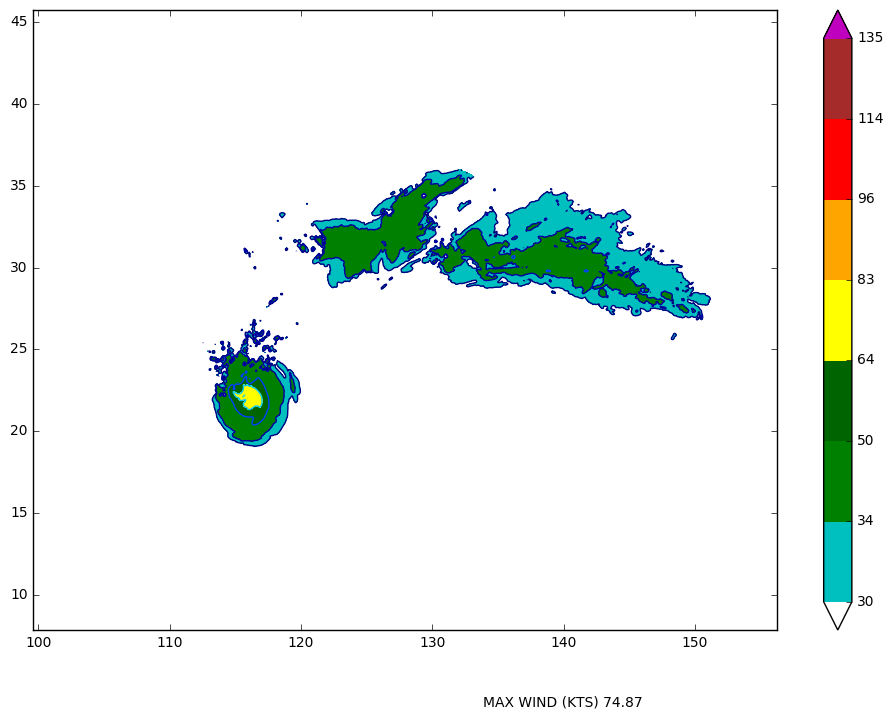

In [63]:
plt.figure(figsize=(12,8))
plt.contourf(xw,yw,mwind,wlevs,cmap=cmap,norm=norm,boundaries=[0]+wlevs+[150.],extend='both')
plt.colorbar()
plt.contour(xw,yw,mwind,wlevs)
plt.figtext(0.5,0.03,'MAX WIND (KTS) '+np.str(mwind.max()))

### geoplot

In [38]:
m = Basemap(projection='cyl',llcrnrlat=minlat,urcrnrlat=maxlat, llcrnrlon=minlon,urcrnrlon=maxlon,resolution='l')    

<IPython.core.display.Javascript object>


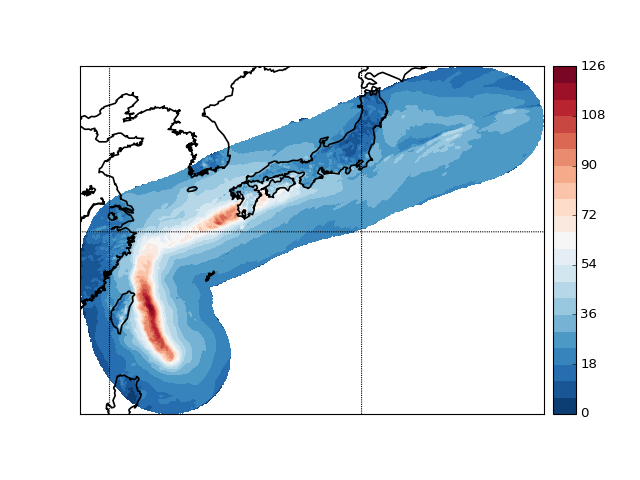

{120.0: ([<matplotlib.lines.Line2D at 0x7fe39cc44a50>], []),
 140.0: ([<matplotlib.lines.Line2D at 0x7fe39cc44e90>], [])}

In [35]:
#%%skip
m.contourf(xw,yw,mwind,20,cmap=plt.cm.RdBu_r,animated=True)
m.colorbar()
m.drawcoastlines(linewidth=1.5)                                                                                                           
m.drawparallels(parallels)                                                                                                                
m.drawmeridians(meridians)                                                                                                                

## compute the range of indeces to extract

Note that the range is -180:180. However when we read the tiff file we set the initial offset and the size of the x-domain. The reader rewinds in the beginning when the size exceeds the available size. 

In [39]:
i1=np.abs(lon-minlon).argmin()
if lon[i1] > minlon: i1=i1-1
i2=np.abs(lon-maxlon).argmin()
if lon[i2] < maxlon: i2=i2+1
                                                                                                                                          
j1=np.abs(lat-minlat).argmin()
if lat[j1] > minlat: j1=j1-1
j2=np.abs(lat-maxlat).argmin()
if lat[j2] < maxlat: j2=j2+1   

In [40]:
print i1,i2,j1,j2

35718 40132 8931 5623


extract from the population file

In [41]:
pop=v.ReadAsArray(i1,j2,i2-i1,j1-j2)

In [42]:
mpop=np.ma.masked_array(pop,pop==nan) # mask the nan values

In [43]:
mpop.shape

(3308, 4414)

In [44]:
#create a lat/lon for analysis and ploting
X=lon[i1:i2]                                                                                                               
Y=lat[j2:j1]                                                                                                               
                                                                                                                                          
x,y=np.meshgrid(X,Y)

In [45]:
x.shape,y.shape

((3308, 4414), (3308, 4414))

In [46]:
mpop.max(), mpop.min()

(91281, 0)

### plot

<IPython.core.display.Javascript object>


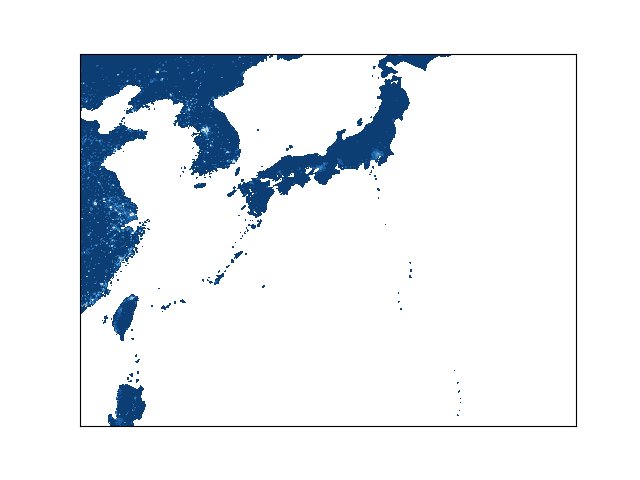

In [52]:
#%%skip
m.contourf(x,y,mpop,20,cmap=plt.cm.RdBu_r,animated=True)

## project wind to pop

In [47]:
orig=pyresample.geometry.SwathDefinition(lons=xw,lats=yw) # the wind grid geometry

In [48]:
targ=pyresample.geometry.SwathDefinition(lons=x,lats=y) # the pop grid geometry

Now we resamble the wind (orig) to the pop grid (targ)....

In [49]:
air_near=pyresample.kd_tree.resample_nearest(orig,np.flipud(mwind),targ,radius_of_influence=500000,fill_value=-999)

In [50]:
print air_near.shape, pop.shape # check that the new resambled grid is the same as the pop grid

(3308, 4414) (3308, 4414)


In [51]:
air_near.min()

0.0

In [52]:
cmap = matplotlib.colors.ListedColormap(['b', 'g','y','r','purple','brown','k']) # custom colormap

In [53]:
cvel=[0,33,63,82,95,112,136]

<IPython.core.display.Javascript object>


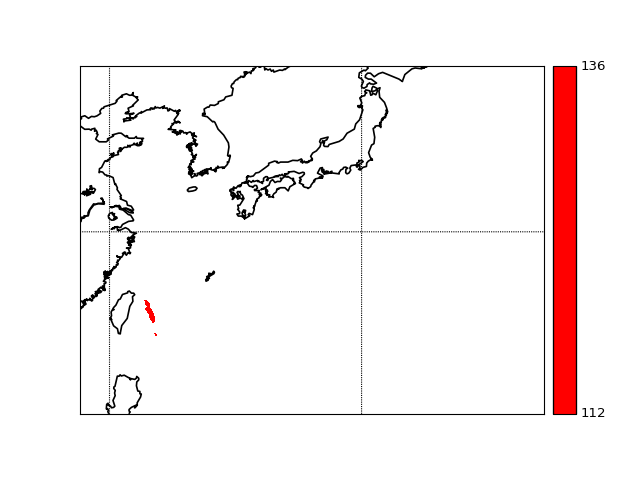

{120.0: ([<matplotlib.lines.Line2D at 0x7f6dac871210>], []),
 140.0: ([<matplotlib.lines.Line2D at 0x7f6dac87ac10>], [])}

In [57]:
#%%skip
#plot
m.contourf(x,y,np.flipud(air_near),cvel[5:7],cmap=cmap)
m.colorbar()
m.drawcoastlines(linewidth=1.5)                                                                                                           
m.drawparallels(parallels)                                                                                                                
m.drawmeridians(meridians)                                                                                                                

#### resample with gauss

This is a different option in resampling by using nearest gauss weighting. For more see https://pyresample.readthedocs.io/en/latest/swath.html

In [59]:
%%skip
air_gauss=pyresample.kd_tree.resample_gauss(orig,np.flipud(mwind),targ,radius_of_influence=500000,neighbours=10, sigmas=250000, fill_value=-999)

In [60]:
%%skip
m.imshow(air_gauss,interpolation='nearest')
m.colorbar()
m.drawcoastlines(linewidth=1.5)                                                                                                           
m.drawparallels(parallels)                                                                                                                
m.drawmeridians(meridians)                                                                                                                


### Classify wind

Now we classify the wind speed based on Saffir-Simpson scale (others can be used as well)

In [59]:
reference = np.array([0,33,63,82,95,112,136,1000]) 
output_labels = ['None', 'TS' ,'CAT. 1','CAT. 2' , 'CAT. 3', 'CAT. 4', 'CAT. 5'] #The value assigned to each interval

In [60]:
sort_idx = np.argsort(reference) # saving the scale indeces 

In [61]:
pos = np.searchsorted(reference[sort_idx], air_near, side = 'left') # sort the wind array

In [62]:
out = np.argsort(reference)[pos] # restore the correct order of the scale, more info in http://stackoverflow.com/questions/31078160/classify-elements-of-a-numpy-array-using-a-second-array-as-reference

In [63]:
outm=np.ma.masked_array(out,air_near.mask)

In [64]:
print out.min(), out.max()

0 6


In [65]:
cmap = matplotlib.colors.ListedColormap(['w', 'b','g','y','r','purple','brown','k']) # custom colormap

In [66]:
#cmap = matplotlib.cm.get_cmap('jet',4)

In [67]:
ti=np.arange(0.,7.) # custom range of colormap

<IPython.core.display.Javascript object>


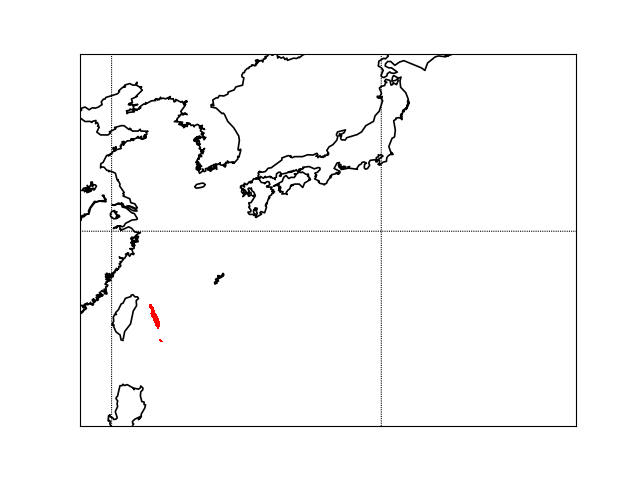

{120.0: ([<matplotlib.lines.Line2D at 0x7f6dac827350>], []),
 140.0: ([<matplotlib.lines.Line2D at 0x7f6dac827790>], [])}

In [68]:
#%%skip
#plot
#m.imshow(out,vmin=1, vmax=2)#, cmap = cmap)#, interpolation='nearest')
m.contourf(x,y,np.flipud(outm),ti[5:7],cmap=cmap)
#m.colorbar( ticks=ti )
#colorbar_index(ncolors=7,cmap=cmap)
m.drawcoastlines(linewidth=1.5)                                                                                                           
m.drawparallels(parallels)                                                                                                                
m.drawmeridians(meridians)                                                                                                                

### Compute population exposure

Here we can create appropriate masks of the wind force and apply it to the population array (mpop)

In [83]:
ma5=outm>5 # all winds > cat. 4

Note that a 'masked' result means 0 

In [84]:
pop5 = mpop[ma5].sum() # summing the mpop array for the above mask
pop5

masked

In [85]:
ma4=outm > 4

In [86]:
pop4 = mpop[ma4].sum()
pop4

8770

In [87]:
ma3=outm > 3

In [88]:
pop3 = mpop[ma3].sum()
pop3

39845

In [89]:
ma2=outm > 2

In [90]:
pop2 = mpop[ma2].sum()
pop2

620845

In [91]:
ma1=(outm > 1)

In [92]:
pop1 = mpop[ma1].sum()
pop1

54044317

In [93]:
ma0=(outm > 0)

In [94]:
pop0 = mpop[ma0].sum()
pop0

324177141

We can estimate the exposure to a specific wind scale by subtracting. E.g. the population exposed to winds category 3 will be those exposed to more than 2 (pop2) - those exposed to more than 3 (pop3)

In [74]:
pop3-pop4  

31075

Another way to test this is to mask the original pop array to the wind force and then exclude the nan values

In [106]:
mask= outm == 1 # all location with wind force 3

In [107]:
np.ma.masked_less(mpop[mask],0).sum() # sould be the same as the above result

270132824

### plot

We can plot the areas of interest as well

In [108]:
mout=np.ma.masked_array(out,mask = out != 1)

In [ ]:
#%%skip
m.imshow(np.flipud(mpop),interpolation='nearest')
m.imshow(mout,vmin=0, vmax=6, cmap = cmap, interpolation='nearest', alpha=0.6)
m.colorbar( ticks=ti )
m.drawcoastlines(linewidth=1.5)                                                                                                           
m.drawparallels(parallels)                                                                                                                
m.drawmeridians(meridians)                                                                                                                


In [132]:
outm1=np.ma.masked_where(outm>=1,outm)

In [ ]:
m.imshow(outm1)

<IPython.core.display.Javascript object>


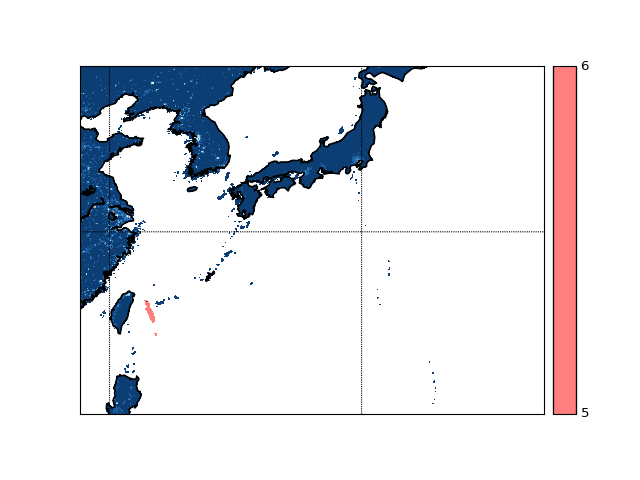

{120.0: ([<matplotlib.lines.Line2D at 0x7f6d9da8ec90>], []),
 140.0: ([<matplotlib.lines.Line2D at 0x7f6d9da9c350>], [])}

In [69]:
#%%skip
m.contourf(x,y,mpop,20,cmap=plt.cm.RdBu_r,animated=True)
m.contourf(x,y,np.flipud(outm),ti[5:7],cmap=cmap,alpha=0.5)
m.colorbar( )#ticks=ti )
m.drawcoastlines(linewidth=1.5)                                                                                                           
m.drawparallels(parallels)                                                                                                                
m.drawmeridians(meridians)                                                                                                                


### Real time test

This is function based on the corresponding Notebook (link) to read the wind swath of the day 


In [89]:
def get_wswath(fname):
    path0='ftp://ftp.ncep.noaa.gov/pub/data/nccf/com/hur/prod/'
    response=urllib2.urlopen(path0)
    ls=response.readlines()
    lp=[elem.strip() for elem in ls]
        
    try:
        urllib.urlretrieve(path0+fname, filename='tmp/wind10m.txt')
    except:
        print 'no such file'
        
    r=pd.read_csv('tmp/wind10m.txt',header=0)
    
    [nj,ni]=r.columns[0].split()[-2:]# the last 2 values of the header define grid size
    ni=np.int(ni)
    nj=np.int(nj)
    nn=ni*nj
    
    wswath=r[:nn]
    s=wswath[wswath.columns[0]].str.split(expand=True)
    s.columns=['lat','lon','wind']
    s=s.apply(pd.to_numeric)
    
    lat=s['lat'].values.reshape(ni,nj) 
    lon=s['lon'].values.reshape(ni,nj)
    wind=s['wind'].values.reshape(ni,nj)
    
    return lat,lon,wind

In [90]:
hlat,hlon,hwind = get_wswath('hwrf.2016092300/twenty20w.2016092300.wind10m.ascii')

In [35]:
def get_pop(wlat,wlon,wind):
    filename='../../POPEXPO/lspop20141.tif' #population data filename
    #define the lat/lon window of wind swath
    minlon=wlon[ wind != -999 ].min()
    maxlon=wlon[ wind != -999 ].max()
    minlat=wlat[ wind != -999 ].min()
    maxlat=wlat[ wind != -999 ].max()
    buf=[minlon,maxlon,minlat,maxlat]
    print buf
    pop=getmap(filename,buf) # read population data
    mpop=np.ma.masked_array(pop.data,pop.data==pop.nan)
    mwind=np.ma.masked_array(wind,wind==-999) #mask the wind data for interpolation
    
    wgeo=pyresample.geometry.SwathDefinition(lons=wlon,lats=wlat) # the wind grid geometry
    pgeo=pyresample.geometry.SwathDefinition(lons=pop.lons,lats=pop.lats) # the pop grid geometry
    air_near=pyresample.kd_tree.resample_nearest(wgeo,np.flipud(mwind),pgeo,radius_of_influence=500000,fill_value=-999)
    
    reference = np.array([0,33,63,82,95,112,136,1000]) 
    output_labels = ['', 'TS' ,'CAT. 1','CAT. 2' , 'CAT. 3', 'CAT. 4', 'CAT. 5'] #The value assigned to each interval
    sort_idx = np.argsort(reference) # saving the scale indeces 
    pos = np.searchsorted(reference[sort_idx], air_near, side = 'left') # sort the wind array
    out = np.argsort(reference)[pos] # restore the correct order of the scale, more info in http://stackoverflow.com/questions/31078160/classify-elements-of-a-numpy-array-using-a-second-array-as-reference
    
    dic={}
    for i in range(7):
        mask= out == i # wind force i
        try:
            npop = np.ma.masked_less(mpop[mask],0).sum() # sum of people exposed to wind force i
            if npop is np.ma.masked :
                dic[output_labels[i]] = 0 
            else:
                dic[output_labels[i]] = npop
        except Exception as e :
            print e
    return dic, mpop

In [ ]:
exposure = get_pop(hlat,hlon,hwind)

In [36]:
exposure, fpop = get_pop(yw,xw,w)

[117.65890522875755, 154.43892973855938, 15.560148777897991, 43.139426142402272]


In [37]:
exposure

{'': 236825547,
 'CAT. 1': 53423472,
 'CAT. 2': 581000,
 'CAT. 3': 31075,
 'CAT. 4': 8770,
 'CAT. 5': 0,
 'TS': 270132824}